# Advanced Econometrics II
### Computer Assignment - Weak identification

In [36]:
import pandas as pd
import os
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
print(os.getcwd())
data = pd.read_csv('dest.csv', 
                header=None, 
                names=['age', 'age2', 'ed',
                       'exper', 'exper2', 'nearc2',
                       'nearc4', 'nearc4a', 'nearc4b',
                       'race', 'smsa', 'south', 'wage'])
print(data.columns.values)

C:\Users\Radim\Documents\GitHub\AdvEcox2
['age' 'age2' 'ed' 'exper' 'exper2' 'nearc2' 'nearc4' 'nearc4a' 'nearc4b'
 'race' 'smsa' 'south' 'wage']


## Question 1

In [37]:
#create data
np.random.seed(111)
rho_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
a_list = [1, 0.6, 0.3, 0.15, 0.07, 0.04, 0.02, 0]
N = 100
k = 10
MC = 5000
Z = np.random.normal(loc=0, scale=1, size=(N, k))
beta_0 = 0
results = np.zeros(MC)
R_freq = np.zeros([len(rho_list), len(a_list)])


for a in a_list:
    for rho in rho_list:
        for l in range(MC):
            pi = np.zeros(k)
            pi[0] = a
            sigma = np.array([[1, rho], [rho, 1]])
            eps_v = np.random.multivariate_normal(mean=[0, 0], cov=sigma, size=(N))
            eps = eps_v[:, 0]
            v = eps_v[:, 1]

            X = Z @ pi + v
            Y = X * beta_0 + eps
            Pz = Z @ np.linalg.inv(Z.T @ Z) @ Z.T


            beta_2SLS = (X.T @ Pz @ X) ** (-1) * (X.T @ Pz @ Y)
            residuals = Y - X.T * beta_2SLS
            #Shat = np.zeros((10, 10))
            #for i in range(Z.shape[1]):
            #    Shat += (N-k) ** (-1) * residuals[i] ** 2 * (np.outer(Z[i, ], Z[i, ]))

            beta_2SLS_var = (N-1) ** (-1) * (Y - X * beta_2SLS).T @ (Y - X * beta_2SLS) *\
                            (X.T @ Pz @ X) ** (-1)
#                             beta_2SLS_var = (N * (X.T @ Pz @ X) ** (-1)) * \
#                             (X.T @ Z @ np.linalg.inv(Z.T @ Z) @ Shat @ np.linalg.inv(Z.T @ Z) @ Z.T @ X) * \
#                             ((X.T @ Pz @ X) ** (-1))

            tstat = (beta_2SLS - beta_0) / np.sqrt(beta_2SLS_var)
            results[l] = (tstat < -1.96) | (tstat > 1.96)
            
        R_freq[rho_list.index(rho), a_list.index(a)] = round(np.mean(results), 3)

In [81]:
print(beta_2SLS_var)

0.0102028600747


       1.00   0.60   0.30   0.15   0.07   0.04   0.02   0.00
0.00  0.045  0.043  0.031  0.021  0.018  0.020  0.015  0.019
0.10  0.049  0.049  0.038  0.032  0.024  0.030  0.026  0.028
0.20  0.052  0.058  0.064  0.066  0.067  0.068  0.061  0.062
0.30  0.061  0.076  0.116  0.130  0.136  0.142  0.136  0.147
0.40  0.071  0.103  0.165  0.235  0.255  0.262  0.260  0.248
0.50  0.080  0.130  0.258  0.368  0.399  0.410  0.418  0.418
0.60  0.099  0.174  0.365  0.520  0.586  0.598  0.613  0.620
0.70  0.116  0.216  0.497  0.693  0.777  0.786  0.790  0.783
0.80  0.132  0.266  0.610  0.851  0.913  0.920  0.923  0.930
0.90  0.160  0.339  0.746  0.948  0.985  0.987  0.989  0.992
0.95  0.182  0.375  0.814  0.981  0.996  0.999  0.999  0.999


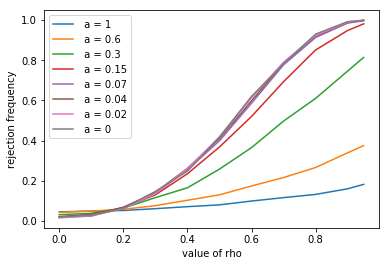

In [40]:
df = pd.DataFrame(R_freq, rho_list)
df.columns = a_list
#df.set_index(rho_list)
print(df)


# for f in range(8):
#     plt.plot(R_freq[:, f])
#     plt.ylabel('rej frequency')
#     plt.title('a is ' + str(a_list[f]))
#     plt.xticks(np.arange(11),rho_list)
#     plt.show()
R_freqt = R_freq.T
num_plots = R_freqt.shape[0]
# colormap = plt.cm.gist_ncar
# plt.gca().set_color_cycle([colormap(i)
#                            for i in np.linspace(0, 0.9, num_plots)])

labels = []
for i in range(num_plots):
    plt.plot(rho_list, R_freqt[i, :])
    labels.append(' a = ' + str(a_list[i]))

plt.legend(labels)
plt.xlabel('value of rho')
plt.ylabel('rejection frequency')
plt.savefig('TS_1.png', dpi=1000)
plt.show()    


## Question 2

In [2]:
import numpy as np
from numpy.linalg import inv as inv
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import time

In [3]:
def projection_matrix(X):
    if X.shape == (X.shape[0],):
        return np.outer(X, X) * ((X.T @ X) ** (-1)) 
    else:
        return X @ np.linalg.inv(X.T @ X) @ X.T
        

def orthogonal_projection_matrix(X):
    return np.identity(X.shape[0]) - projection_matrix(X)

def pi_sim(y, X, betaH0, Z):
    
    N = Z.shape[0]
    k = Z.shape[1]
    
    eps = y - X * betaH0
    sigma_eps_hat = (1 / (N - k)) * eps.T @ orthogonal_projection_matrix(Z) @ eps
    sigma_eps_V_hat = (1 / (N - k)) * eps.T @ orthogonal_projection_matrix(Z) @ X
    sigma_V_eps_hat = (1 / (N - k)) * X.T @ orthogonal_projection_matrix(Z) @ eps
    sigma_V_hat = (1 / (N - k)) * X.T @ orthogonal_projection_matrix(Z) @ X
    
    rho_hat = sigma_eps_V_hat / sigma_eps_hat
    
    pi_sim = inv(Z.T @ Z) @ Z.T @ (X - eps * rho_hat)
    
    return pi_sim, sigma_eps_hat, sigma_eps_V_hat, sigma_V_eps_hat, sigma_V_hat
    
def k_AR_r_LM_beta(y, X, betaH0, Z):
    pi, sigma_eps_hat, sigma_eps_V_hat, sigma_V_eps_hat, sigma_V_hat = pi_sim(y, X, betaH0, Z)
    
    sigma_hat_VV_dot_eps = sigma_V_hat - (sigma_V_eps_hat * sigma_eps_V_hat) / sigma_eps_hat
    
    k_AR_beta = (1 / sigma_eps_hat) * eps.T @ projection_matrix(Z) @ eps
    r_beta = (1 / sigma_hat_VV_dot_eps) * pi.T @ (Z.T @ Z) @ pi    
    LM_beta = (1 / sigma_eps_hat) * eps.T @ projection_matrix(Z @ pi) @ eps
    
    return k_AR_beta, r_beta, LM_beta

def LR_beta(y, X, betaH0, Z):
    k_AR_beta, r_beta, LM_beta = k_AR_r_LM_beta(y, X, betaH0, Z)
    
    return (0.5) * (k_AR_beta - r_beta + np.sqrt((k_AR_beta + r_beta) ** 2 - 4 * r_beta * (k_AR_beta - LM_beta)))

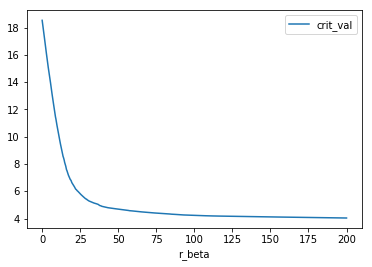

4.037024896682752

In [66]:
k = 10
MC = 5000

r_beta = np.arange(0, 200.25, 0.25)

crit_val_95 = pd.DataFrame({'r_beta' : [], 'crit_val' : []})

for r in r_beta:
    np.random.seed(1211)
    vidle_1 = np.random.chisquare(df=1, size=([MC, 1]))
    vidle_k = np.random.chisquare(df=k - 1, size=([MC, 1]))
    
    LR = 0.5 * (vidle_k + vidle_1 - r + np.sqrt((vidle_k + vidle_1 + r) ** 2 - 4 * r * vidle_k))
    
    LR_crit_val = np.percentile(LR, q=95, interpolation='higher')
    
    crit_val_95 = crit_val_95.append(pd.DataFrame({'r_beta' : [r], 'crit_val' : [LR_crit_val]}), ignore_index=True)

crit_val_95.plot(x='r_beta', y='crit_val')
plt.show()

min(crit_val_95.loc[:, 'crit_val'])

## Question 3

In [4]:
#create data
np.random.seed(1211)
rho_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
a_list = [1, 0.6, 0.3, 0.15, 0.07, 0.04, 0.02, 0]
N = 100
k = 10
MC = 5000
Z = np.random.normal(loc=0, scale=1, size=(N, k))
beta_0 = 0
LR_reject = np.zeros(MC)
r_beta = np.zeros(MC)
R_freq = pd.DataFrame({'r_beta': [], 'LR' : []})

results_ar = np.zeros(MC)
R_freq_AR = np.zeros([len(rho_list), len(a_list)])
results_sc = np.zeros(MC)
R_freq_SC = np.zeros([len(rho_list), len(a_list)])
results_lr = np.zeros(MC)
R_freq_LR = np.zeros([len(rho_list), len(a_list)])
start = time.time()

for a in a_list:
    for rho in rho_list:
         
        vidle_1 = (np.random.chisquare(df=1, size=(1000)))
        vidle_k = (np.random.chisquare(df=k - 1, size=(1000)))
#         r = k_AR_r_LM_beta(Y, X, beta_0, Z)[1]
#         LR_MC = 0.5 * (vidle_k + vidle_1 - r + np.sqrt((vidle_k + vidle_1 + r) ** 2 - 4 * r * vidle_k))
        
            
        for l in range(MC):
            pi = np.zeros(k)
            pi[0] = a
            sigma = np.array([[1, rho], [rho, 1]])
            eps_v = np.random.multivariate_normal(mean=[0, 0], cov=sigma, size=(N))
            eps = eps_v[:, 0]
            v = eps_v[:, 1]

            X = Z @ pi + v
            Y = X * beta_0 + eps
            
            #AR stat
            arstat = k_AR_r_LM_beta(Y, X, beta_0, Z)[0]
            results_ar[l] = arstat > (18.3)
            R_freq_AR[rho_list.index(rho), a_list.index(a)] = round(np.mean(results_ar), 3)
            
            #LM/score stat
            scstat = k_AR_r_LM_beta(Y, X, beta_0, Z)[2]
            results_sc[l] = scstat > 3.84
            R_freq_SC[rho_list.index(rho), a_list.index(a)] = round(np.mean(results_sc), 3)
            
            #LR stat
            r = k_AR_r_LM_beta(Y, X, beta_0, Z)[1]
            LR_MC = 0.5 * (vidle_k + vidle_1 - r + np.sqrt((vidle_k + vidle_1 + r) ** 2 - 4 * r * vidle_k))
        
            lrstat = LR_beta(Y, X, beta_0, Z)
            results_lr[l] = lrstat >  np.percentile(LR_MC, q=95, interpolation='higher')
            R_freq_LR[rho_list.index(rho), a_list.index(a)] = round(np.mean(results_lr), 3)
            
   
            
        #R_freq = R_freq.append(pd.DataFrame({'r_beta' : [k_AR_r_LM_beta(Y, X, beta_0, Z)[1]], 'LR' : np.mean(LR_reject)}),
        #                     ignore_index=True)
    
end = time.time()
print('time elapsed:' + str(end-start))

time elapsed:1174.322906255722


       1.00   0.60   0.30   0.15   0.07   0.04   0.02   0.00
0.00  0.053  0.060  0.052  0.055  0.061  0.064  0.064  0.069
0.10  0.053  0.051  0.062  0.058  0.068  0.063  0.069  0.064
0.20  0.057  0.056  0.056  0.058  0.066  0.067  0.064  0.067
0.30  0.057  0.054  0.061  0.063  0.059  0.068  0.066  0.066
0.40  0.056  0.055  0.061  0.061  0.066  0.065  0.066  0.062
0.50  0.054  0.047  0.060  0.068  0.064  0.061  0.068  0.064
0.60  0.055  0.057  0.061  0.064  0.064  0.068  0.061  0.072
0.70  0.054  0.053  0.057  0.066  0.063  0.059  0.065  0.069
0.80  0.057  0.053  0.051  0.060  0.068  0.066  0.070  0.061
0.90  0.055  0.052  0.062  0.056  0.066  0.060  0.069  0.065
0.95  0.056  0.047  0.051  0.058  0.059  0.059  0.068  0.069


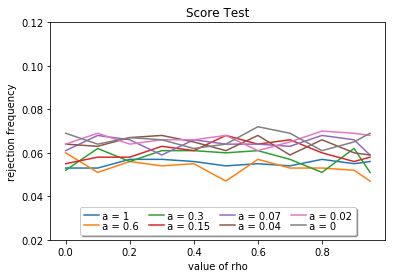

       1.00   0.60   0.30   0.15   0.07   0.04   0.02   0.00
0.00  0.063  0.065  0.059  0.066  0.063  0.066  0.069  0.070
0.10  0.057  0.065  0.067  0.062  0.070  0.069  0.069  0.074
0.20  0.065  0.067  0.068  0.067  0.065  0.074  0.065  0.070
0.30  0.068  0.070  0.065  0.072  0.066  0.065  0.067  0.067
0.40  0.073  0.064  0.069  0.060  0.060  0.070  0.065  0.059
0.50  0.065  0.065  0.067  0.067  0.066  0.067  0.070  0.065
0.60  0.071  0.071  0.067  0.069  0.068  0.072  0.069  0.059
0.70  0.070  0.065  0.068  0.068  0.068  0.060  0.060  0.066
0.80  0.065  0.068  0.064  0.066  0.068  0.064  0.068  0.065
0.90  0.070  0.062  0.070  0.067  0.069  0.065  0.066  0.066
0.95  0.068  0.067  0.074  0.063  0.069  0.067  0.064  0.066


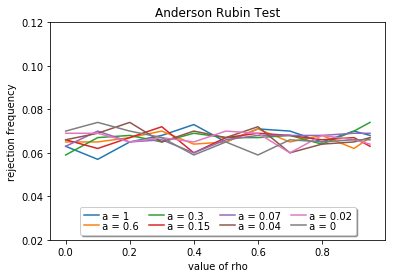

       1.00   0.60   0.30   0.15   0.07   0.04   0.02   0.00
0.00  0.053  0.057  0.067  0.063  0.064  0.071  0.076  0.058
0.10  0.041  0.045  0.087  0.072  0.072  0.071  0.084  0.071
0.20  0.069  0.062  0.063  0.076  0.077  0.083  0.050  0.077
0.30  0.057  0.056  0.061  0.068  0.055  0.074  0.069  0.058
0.40  0.078  0.054  0.059  0.055  0.065  0.086  0.083  0.059
0.50  0.038  0.054  0.073  0.082  0.076  0.056  0.089  0.084
0.60  0.053  0.063  0.065  0.054  0.070  0.084  0.073  0.057
0.70  0.055  0.059  0.056  0.068  0.075  0.061  0.065  0.086
0.80  0.064  0.058  0.068  0.059  0.061  0.062  0.066  0.068
0.90  0.048  0.063  0.050  0.056  0.075  0.071  0.066  0.067
0.95  0.053  0.041  0.055  0.065  0.066  0.072  0.072  0.069


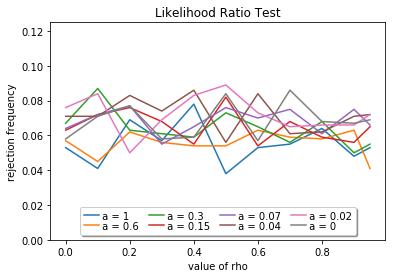

In [17]:
#SC
dfSC = pd.DataFrame(R_freq_SC, rho_list)
dfSC.columns = a_list
print(dfSC)

R_freqSCt = R_freq_SC.T
num_plots = R_freqSCt.shape[0]
# colormap = plt.cm.gist_ncar
# plt.gca().set_color_cycle([colormap(i)
#                            for i in np.linspace(0, 0.9, num_plots)])

labels = []
for i in range(num_plots):
    plt.plot(rho_list, R_freqSCt[i, :])
    labels.append(' a = ' + str(a_list[i]))

plt.legend(labels, ncol=4, loc='lower center', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)
plt.ylim( (0.02, 0.12) )
plt.title('Score Test')
plt.xlabel('value of rho')
plt.ylabel('rejection frequency')
plt.savefig('SC_3.png', dpi=1000)
plt.show()


#AR
dfAR = pd.DataFrame(R_freq_AR, rho_list)
dfAR.columns = a_list
print(dfAR)

R_freqARt = R_freq_AR.T
num_plots = R_freqARt.shape[0]
#colormap = plt.cm.gist_ncar
#plt.gca().set_prop_cycle([plt.cm.spectral(i) for i in np.linspace(0, 1, 8)])
#plt.set_prop_cycle('color',plt.cm.spectral(np.linspace(0,1,8)))

#ax.set_prop_cycle('color',plt.cm.spectral(np.linspace(0,1,30)))

labels = []
for i in range(num_plots):
    plt.plot(rho_list, R_freqARt[i, :])
    labels.append(' a = ' + str(a_list[i]))

plt.legend(labels, ncol=4, loc='lower center', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)
plt.ylim( (0.02, 0.12) )
plt.title('Anderson Rubin Test')
plt.xlabel('value of rho')
plt.ylabel('rejection frequency')
plt.savefig('AR_3', dpi=1000)
plt.show()   


#LR
dfLR = pd.DataFrame(R_freq_LR, rho_list)
dfLR.columns = a_list
print(dfLR)

R_freqLRt = R_freq_LR.T
num_plots = R_freqLRt.shape[0]
# colormap = plt.cm.gist_ncar
# plt.gca().set_color_cycle([colormap(i)
#                            for i in np.linspace(0, 0.9, num_plots)])

labels = []
for i in range(num_plots):
    plt.plot(rho_list, R_freqLRt[i, :])
    labels.append(' a = ' + str(a_list[i]))

plt.legend(labels, ncol=4, loc='lower center', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)
plt.ylim( (0, 0.125) )
plt.title('Likelihood Ratio Test')
plt.xlabel('value of rho')
plt.ylabel('rejection frequency')
plt.savefig('LR_3.png',dpi=1000)
plt.show()


## Question 5

In [41]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from numpy.linalg import inv as inv
import scipy.stats as stats

data = pd.read_csv('dest.csv', 
                header=None, 
                names=['age', 'age2', 'ed',
                       'exper', 'exper2', 'nearc2',
                       'nearc4', 'nearc4a', 'nearc4b',
                       'race', 'smsa', 'south', 'wage'])

ys = data.loc[:, 'wage'].values
Xs = data.loc[:, 'ed'].values
#Z = data.loc[:, ['nearc2', 'nearc4', 'nearc4a', 'nearc4b']]
W_noC = data.loc[:, ['exper', 'exper2', 'south', 'smsa', 'race']]
constant = pd.DataFrame({'constant' : np.ones(W_noC.shape[0])})
W = pd.concat([W_noC, constant], axis=1).values

In [44]:
Zs = data.loc[:, 'nearc2'].values
Zs = Zs.reshape((Zs.shape[0], 1))

Mw = orthogonal_projection_matrix(W)

y = Mw @ ys
X = Mw @ Xs
Z = Mw @ Zs

Coverage frequency for AR:  0.92039800995
Coverage frequency for t:  0.0398009950249


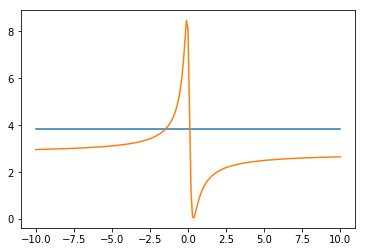

-0.043331005098 0.742863302341
Wall time: 41.5 s


In [60]:
%%time
np.random.seed(1211)
N = Z.shape[0]
k = Z.shape[1]
beta = list(np.arange(-10, 10.1, 0.1))
beta = [round(b, 1) for b in beta]

CV_chi2 = stats.chi2.ppf(q=0.95, df=k) / k
AR_stat = np.zeros(len(beta))
t_stat = np.zeros(len(beta))

beta_2SLS = (X.T @ projection_matrix(Z) @ X) ** (-1) * (X.T @ projection_matrix(Z) @ y)
beta_2SLS_var = (N - 1) ** (-1) * (y - X * beta_2SLS).T @ (y - X * beta_2SLS) *\
                            (X.T @ projection_matrix(Z) @ X) ** (-1)

for b in beta:    
    np.random.seed(1211)
    
    eps = y - X * b
    AR_stat[beta.index(b)] = ((eps.T @ projection_matrix(Z) @ eps) / k) / ((eps.T @ orthogonal_projection_matrix(Z) @ eps) / (N - k))
    t_stat[beta.index(b)] = (beta_2SLS - b) / np.sqrt(beta_2SLS_var)
    

print('Coverage frequency for AR: ', np.mean(AR_stat <= CV_chi2))
print('Coverage frequency for t: ', np.mean((t_stat < 1.96) & (t_stat > -1.96)))

plt.plot(beta, np.repeat(CV_chi2, AR_stat.shape[0]))
plt.plot(beta, AR_stat)
#plt.plot(beta, t_stat)
plt.show()
print(beta_2SLS-1.96*np.sqrt(beta_2SLS_var), beta_2SLS+1.96*np.sqrt(beta_2SLS_var))

#### subquestion g

In [40]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from numpy.linalg import inv as inv
import scipy.stats as stats

def projection_matrix(X):
    if X.shape == (X.shape[0],):
        X = X.reshape((X.shape[0], 1))
        
    return X @ np.linalg.inv(X.T @ X) @ X.T

data = pd.read_csv('dest.csv', 
                header=None, 
                names=['age', 'age2', 'ed',
                       'exper', 'exper2', 'nearc2',
                       'nearc4', 'nearc4a', 'nearc4b',
                       'race', 'smsa', 'south', 'wage'])

ys = data.loc[:, 'wage'].values
Xs = data.loc[:, 'ed'].values
#Z = data.loc[:, ['nearc2', 'nearc4', 'nearc4a', 'nearc4b']]
W_noC = data.loc[:, ['exper', 'exper2', 'south', 'smsa', 'race']]
constant = pd.DataFrame({'constant' : np.ones(W_noC.shape[0])})
W = pd.concat([W_noC, constant], axis=1).values

Zs = data.loc[:, ['nearc4', 'nearc2', 'nearc4a', 'nearc4b']].values


Mw = orthogonal_projection_matrix(W)

y = Mw @ ys
X = Mw @ Xs
Z = Mw @ Zs

X = X.reshape((X.shape[0],1))
y = y.reshape((y.shape[0],1))

#g
beta_2SLS = (X.T @ projection_matrix(Z) @ X) ** (-1) * (X.T @ projection_matrix(Z) @ y)
u_hat = y - X @ beta_2SLS

OIR = (N-X.shape[1])*(u_hat.T @ projection_matrix(Z) @ u_hat)/(np.sum(u_hat ** 2))

print('OIR statistic is: ' + str(float(OIR)))
      
print('Critical value for the above statistic is: ' + str(stats.chi2.ppf(q=0.95, df = Z.shape[1] - X.shape[1])))

OIR statistic is: 2.844809984800318
Critical value for the above statistic is: 7.81472790325


In [30]:
u_hat

array([[ 0.58933297],
       [-0.02166208],
       [-0.05996399],
       ..., 
       [ 0.48410091],
       [ 0.29904258],
       [ 0.37428347]])